In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from scipy import stats

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Load the Data

In [2]:
survey_url='https://www.dropbox.com/scl/fi/2vr44w3nk2denmjizy6lf/survey_data.dta?rlkey=1ykg6l4brzv1fhouuchwtkm5z&st=isrxyf9k&dl=1'
survey_df = pd.read_stata(survey_url)

## Task 4 - Survey Data Analysis

### Part A - Core Survey Metrics

#### Overall response rate and response rate by treatment

In [ ]:
survey_df.shape

(4222, 281)

In [ ]:
# standardize the values
survey_df['status_survey'] = survey_df['status_survey'].astype(str).str.lower()

completed = survey_df[survey_df['status_survey']=='completed']

# response rates
overall_response_rate = len(completed) / len(survey_df)
by_treat = (completed.groupby('treatment_s')['prop_id'].count()/ survey_df.groupby('treatment_s')['prop_id'].count())

print("Overall response rate:", round(overall_response_rate*100, 2), "%")
print("\nResponse rate by treatment arm:")
print((by_treat*100).round(2))


Overall response rate: 34.04 %

Response rate by treatment arm:
treatment_s
Correcting Misperceptions       35.38
Elite Capture                   33.04
No Correcting Misperceptions    33.66
Public Goods                    34.15
Revenue Leakage                 33.71
Spending Leakage                34.23
Name: prop_id, dtype: float64


###Treatment balance on: property land area, built area, number of storeys, age

In [ ]:
# ensure relevant variables are numeric
for col in ['land', 'built', 'storeys', 'age']:
    survey_df[col] = pd.to_numeric(survey_df[col], errors='coerce')

# standardise gender and education text
survey_df['gender'] = survey_df['gender'].astype(str).str.strip().str.lower()
survey_df['education'] = survey_df['education'].astype(str).str.strip().str.lower()

balance_vars = ['land', 'built', 'storeys', 'age']
summary_means = survey_df.groupby('treatment_s')[balance_vars].mean().round(2)
summary_stds = survey_df.groupby('treatment_s')[balance_vars].std().round(2)

print("Means by treatment arm:")
print(summary_means)
print("\nStandard deviations by treatment arm:")
print(summary_stds)


Means by treatment arm:
                              land    built  storeys    age
treatment_s                                                
Correcting Misperceptions     6.45  1551.26     1.87  41.65
Elite Capture                 6.09  1400.56     1.86  41.03
No Correcting Misperceptions  6.31  1473.72     1.80  47.74
Public Goods                  5.97  1561.93     1.88  42.02
Revenue Leakage               6.64  1542.74     1.81  41.53
Spending Leakage              6.16  1509.73     1.84  41.87

Standard deviations by treatment arm:
                               land    built  storeys     age
treatment_s                                                  
Correcting Misperceptions     14.47  1441.68     0.80    7.76
Elite Capture                 11.30  1204.22     0.93    7.85
No Correcting Misperceptions   8.94  1226.35     0.76  149.15
Public Goods                   7.63  1375.43     0.75    8.09
Revenue Leakage               11.68  1660.99     0.79    7.81
Spending Leakage       

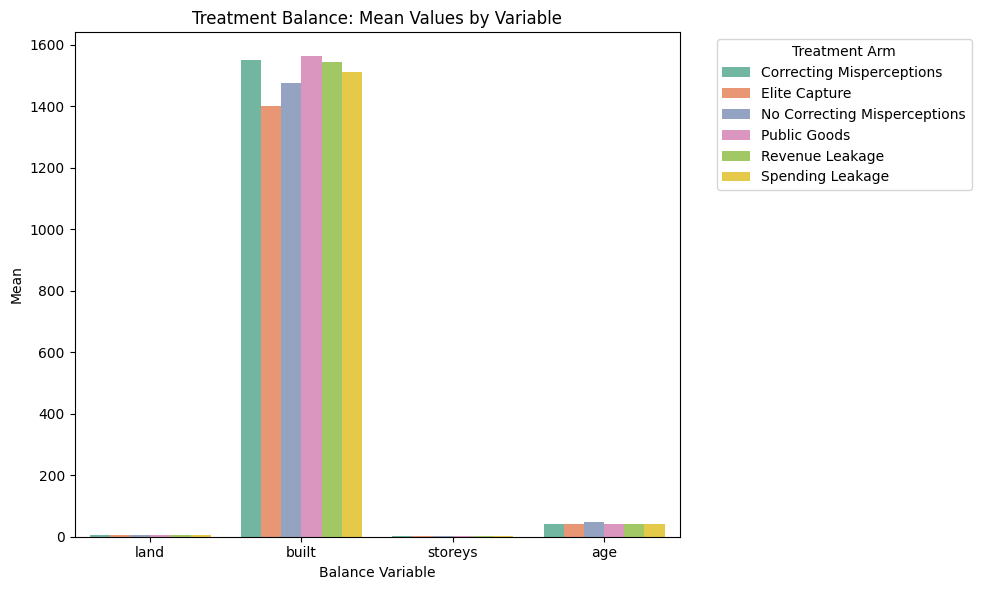

In [ ]:
mean_long = (
    summary_means
    .reset_index()
    .melt(id_vars='treatment_s', var_name='variable', value_name='mean')
)

plt.figure(figsize=(10,6))
sns.barplot(
    data=mean_long,
    x='variable', y='mean', hue='treatment_s',
    palette='Set2'
)
plt.title('Treatment Balance: Mean Values by Variable')
plt.ylabel('Mean')
plt.xlabel('Balance Variable')
plt.legend(title='Treatment Arm', bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout()
plt.show()


### Treatment balance on gender

In [ ]:
# Gender distribution (% male)
gender_dist = (
    survey_df.groupby('treatment_s')['gender']
      .apply(lambda x: (x == 'male').mean() * 100)
      .round(1)
)
print("\n% Male by treatment arm:")
print(gender_dist)



% Male by treatment arm:
treatment_s
Correcting Misperceptions       73.4
Elite Capture                   70.9
No Correcting Misperceptions    71.3
Public Goods                    70.9
Revenue Leakage                 68.1
Spending Leakage                72.1
Name: gender, dtype: float64


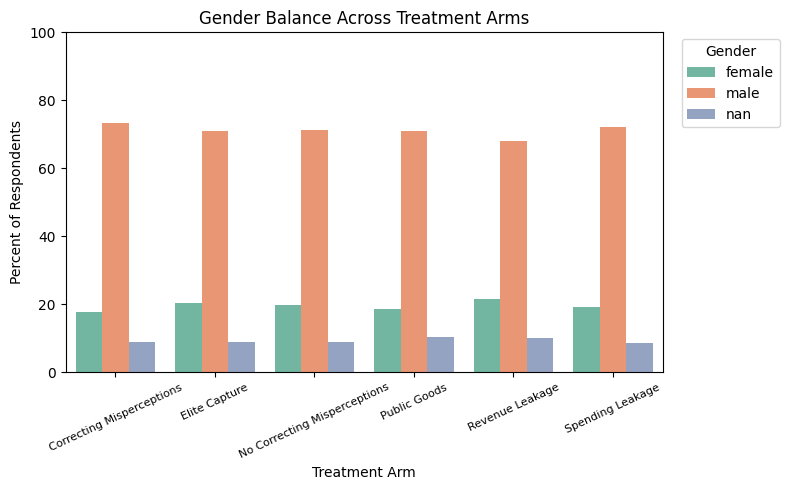

In [ ]:
gender_dist = (
    survey_df.groupby(['treatment_s', 'gender'])
      .size()
      .reset_index(name='count')
)
gender_dist['percent'] = gender_dist.groupby('treatment_s')['count'].transform(lambda x: 100 * x / x.sum())

plt.figure(figsize=(8,5))
sns.barplot(data=gender_dist, x='treatment_s', y='percent', hue='gender', palette='Set2')
plt.title('Gender Balance Across Treatment Arms')
plt.xlabel('Treatment Arm')
plt.xticks(rotation=25, fontsize=8)
plt.ylabel('Percent of Respondents')
plt.ylim(0, 100)
plt.legend(title='Gender', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()


### Treatment balance on education

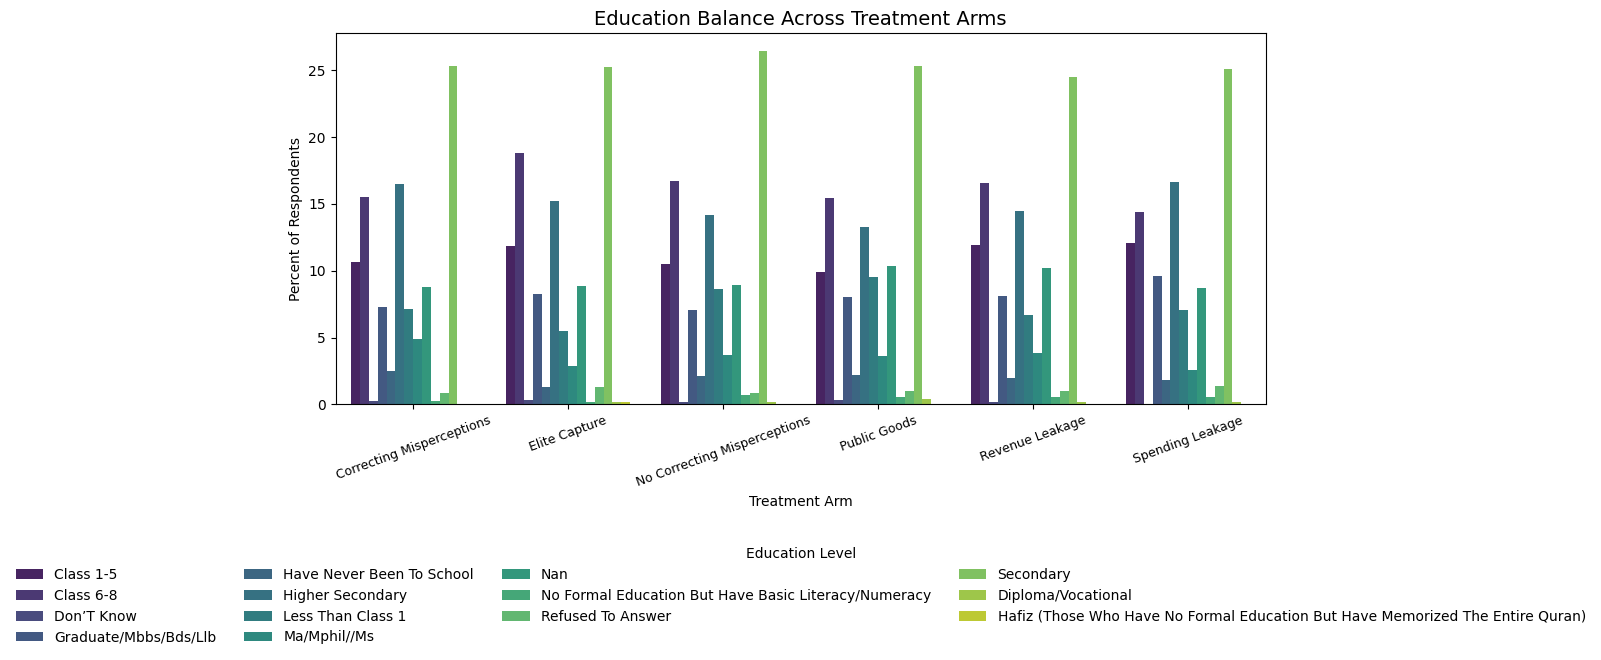

In [ ]:
# Standardise education
survey_df['education'] = survey_df['education'].astype(str).str.strip().str.title()

# Drop missing treat or education values
df = survey_df.dropna(subset=['treatment_s', 'education'])

# Compute % composition of education within each treatment arm
edu_dist = (
    df.groupby(['treatment_s', 'education'])
      .size()
      .reset_index(name='count')
)
edu_dist['percent'] = edu_dist.groupby('treatment_s')['count'].transform(lambda x: 100 * x / x.sum())

plt.figure(figsize=(12,7))
sns.barplot(
    data=edu_dist,
    x='treatment_s', y='percent', hue='education',
    palette='viridis'
)
plt.title('Education Balance Across Treatment Arms', fontsize=14)
plt.xlabel('Treatment Arm')
plt.xticks(rotation=20, fontsize=9)
plt.ylabel('Percent of Respondents')

plt.legend(
    title='Education Level',
    bbox_to_anchor=(0.5, -0.35),   # place legend below
    loc='upper center',
    ncol=4,
    frameon=False
)
plt.subplots_adjust(bottom=0.35)
plt.show()

### Asset Index

#### Variable choices:

s13_q9: Do you have backup power through generators/UPS in the event of outages?

  s1_q13: Air Cooler

  s1_q14: Air Conditioner

  s1_q18: Motorcycle/Scooter

  s1_q19: Car or Truck

Justification: The  variables capture major indicators of household wealth commonly used in surveys like the World Bank’s LSMS and DHS. These indicators tell us about  infrastructure access (e.g., reliable electricity through generators or UPS) and ownership of durable goods that signify comfort, mobility, and purchasing power. Together they hint on socioeconomic status.

Explained variance by PC1: 45.26%
PCA Loadings:
 s1_q18    0.768515
s1_q13    0.454381
s1_q14    0.408766
s1_q19    0.158611
s13_q9    0.103324
dtype: float64


/tmp/ipython-input-1110115290.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  assets = survey_df[asset_vars].astype('object').replace(mapping)
/tmp/ipython-input-1110115290.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  survey_df['asset_index'] = pca.fit_transform(assets)


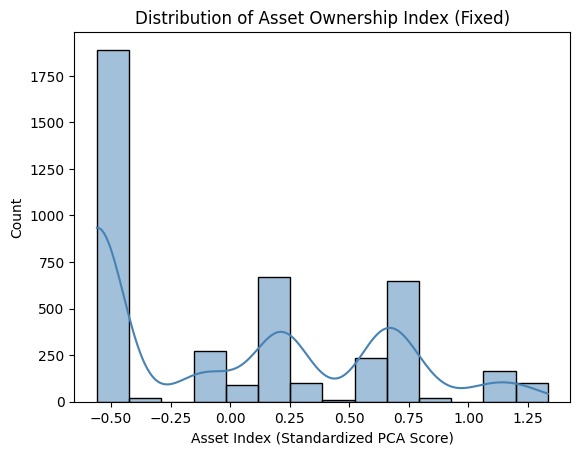

In [ ]:
mapping = {"Yes": 1, "No": 0, "Don’t know": np.nan}
asset_vars = ['s13_q9','s1_q13','s1_q14','s1_q18','s1_q19']
assets = survey_df[asset_vars].astype('object').replace(mapping)

# Ensure numeric and fill NAs with 0
assets = assets.apply(pd.to_numeric, errors='coerce').fillna(0)

# PCA
pca = PCA(n_components=1)
survey_df['asset_index'] = pca.fit_transform(assets)

# Check variance explained and loadings
explained_var = pca.explained_variance_ratio_[0]
print(f"Explained variance by PC1: {explained_var:.2%}")

loadings = pd.Series(pca.components_[0], index=asset_vars).sort_values(ascending=False)
print("PCA Loadings:\n", loadings)

# Plot
sns.histplot(survey_df['asset_index'], kde=True, color='steelblue')
plt.title('Distribution of Asset Ownership Index (Fixed)')
plt.xlabel('Asset Index (Standardized PCA Score)')
plt.show()

## Attitudes & Preferences Module

### Tax Knowledge Index

#### Variables:
s2_q1: as your property tax for previous year levied on the market value of your property or the rental value of your property?

s2_q4: What would the owner’s property tax be after renting, if he was paying Rs 100 for the self occupied property?

s2_q7: Which of these is the prevailing property tax rate in Lahore?

s2_q8: Which of these properties is exempt from the payment of property tax in Lahore?

s2_q9: nder the existing system, which of the following institutions sets the property tax rate for Lahore

s3_q2: Can you please calcuate the tax rate of property A

s3_q3: Can you please calcuate the tax rate of property B

s3_q4: Can you please tell which of these properties bears a higher property tax rate


In [ ]:
questions = ['s2_q1','s2_q4','s2_q7','s2_q8_1','s2_q8_2','s2_q8_3','s2_q8_4','s2_q9','s3_q2','s3_q3','s3_q4']

# ensure numeric
num_cols = ['s2_q4','s3_q2','s3_q3']
survey_df[num_cols] = survey_df[num_cols].apply(pd.to_numeric, errors='coerce')

# Ground truth answers (based on my assumptions)
correct = {
    's2_q1':  'market value',
    's2_q4':  200,
    's2_q7':  "5% of a property's annual value",
    's2_q8_1': "Yes",
    's2_q8_2': "No",
    's2_q8_3': "No",
    's2_q8_4': "No",
    's2_q9':  'The Cabinet of the Punjab Government',
    's3_q2':  0.15,
    's3_q3':  0.10,
    's3_q4':  'Property B',
}

# Build a boolean frame: True = correct
correct_mask = pd.DataFrame({
    col: (
        np.isclose(survey_df[col].astype(float), ans, rtol=0, atol=1e-9)
        if isinstance(ans, (int, float))
        else (survey_df[col] == ans)
    )
    for col, ans in correct.items()
}, index=survey_df.index)

survey_df = survey_df.assign(
    knowledge_correct_count = correct_mask.sum(axis=1),
    knowledge_index = correct_mask.sum(axis=1) / len(correct)
)
survey_df['knowledge_index'].describe()

,knowledge_index
count,4222.000000
mean,0.088691
std,0.188379
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,0.727273


#### Knowledge index by education

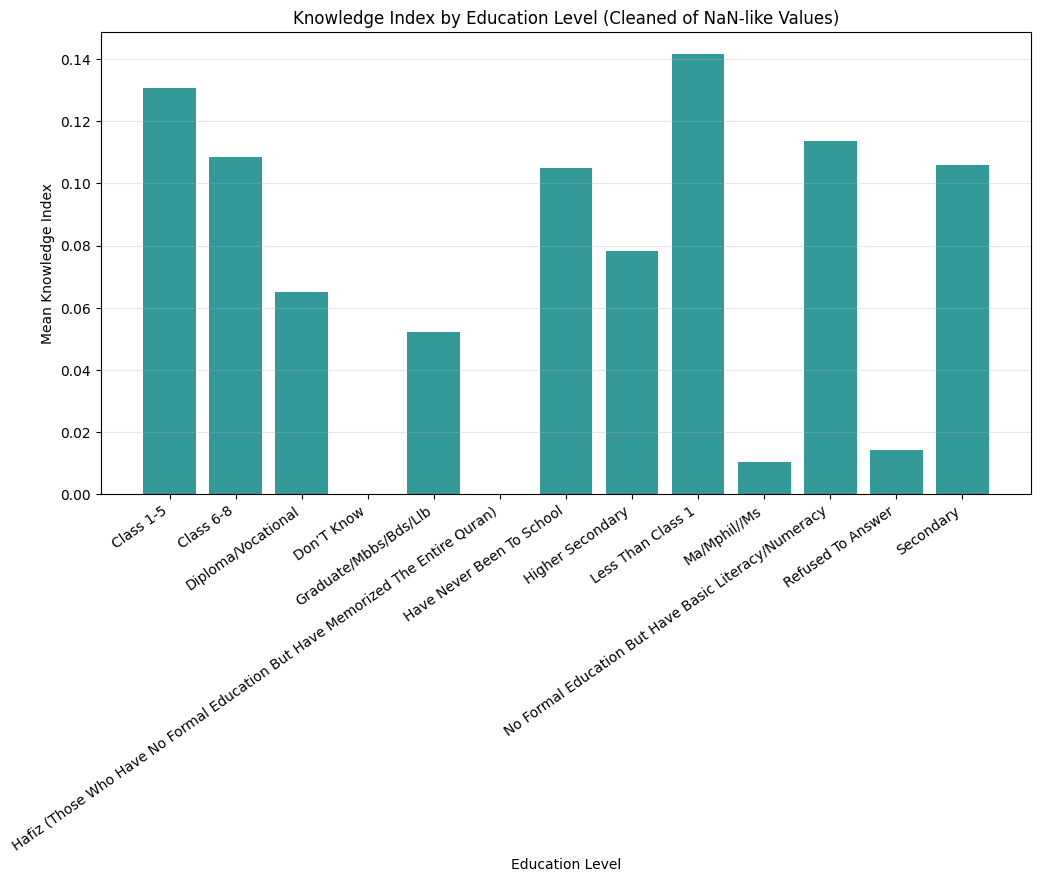

In [ ]:
# Define all NaN-like strings to exclude
nan_like = ['nan', 'Nan', 'NaN', '', ' ']

edu_df = survey_df[
    survey_df['education'].notna() &
    (~survey_df['education'].astype(str).str.strip().isin(nan_like))
]

edu_kn = edu_df.groupby('education', as_index=False)['knowledge_index'].mean()

plt.figure(figsize=(12,6))
plt.bar(edu_kn['education'], edu_kn['knowledge_index'], color='teal', alpha=0.8)
plt.title('Knowledge Index by Education Level (Cleaned of NaN-like Values)')
plt.xlabel('Education Level')
plt.ylabel('Mean Knowledge Index')
plt.xticks(rotation=35, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.show()


#### Knowledge index vs asset index

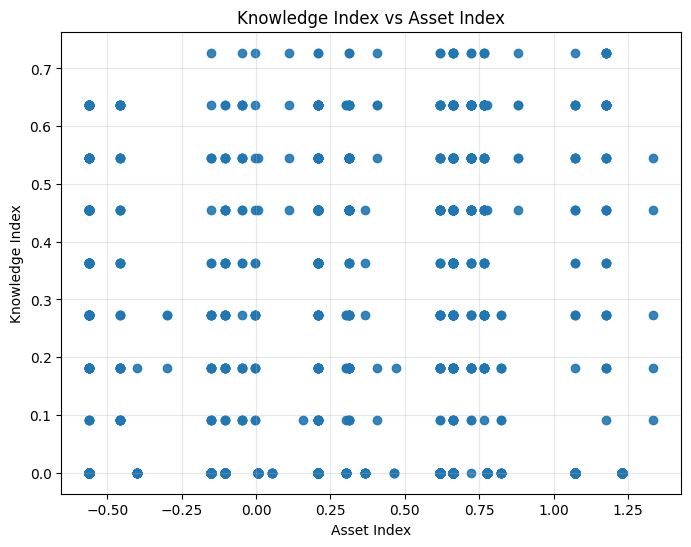

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(survey_df['asset_index'], survey_df['knowledge_index'], alpha=0.9)
plt.title('Knowledge Index vs Asset Index')
plt.xlabel('Asset Index')
plt.ylabel('Knowledge Index')
plt.grid(alpha=0.3)
plt.show()

# No obvious pattern

#### Knowledge index by gender

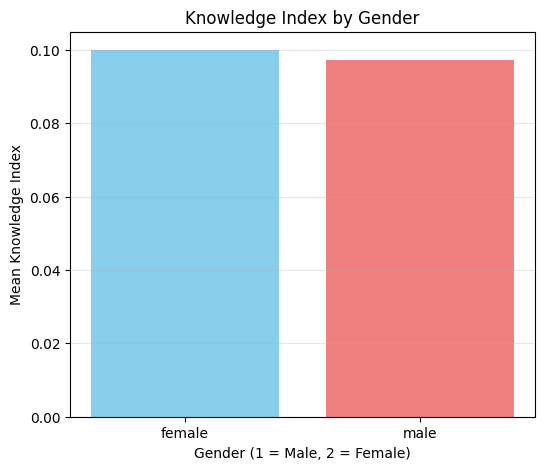

In [ ]:
gender_df = survey_df[
    (~survey_df['gender'].astype(str).str.strip().isin(nan_like))
]
gender_kn = gender_df.groupby('gender', as_index=False)['knowledge_index'].mean()

plt.figure(figsize=(6,5))
plt.bar(gender_kn['gender'], gender_kn['knowledge_index'], color=['skyblue','lightcoral'])
plt.title('Knowledge Index by Gender')
plt.xlabel('Gender (1 = Male, 2 = Female)')
plt.ylabel('Mean Knowledge Index')
plt.grid(axis='y', alpha=0.3)
plt.show()

# no difference

### Trust Scale (tax staff, government, citizens)

#### Variables:

g2_12: Generally speaking, on a scale of 1-5, where 1 is not at all, and 5 is fully, how much you would say that you trust the property tax staff.

g2_13: Generally speaking, on a scale of 1-5, where 1 is not at all, and 5 is fully, how much you would say that you trust the government?

g2:15: Generally speaking, on a scale of 1-5, where 1 is not at all, and 5 is fully, how much you would say that you trust other citizens of Lahore

In [ ]:
trust_vars = ['g2_12', 'g2_13', 'g2_15']

# code from text to numeric
trust_map = {
    'No trust at all': 1,
    'Trust a little too much': 2,
    'Trust neither more nor less': 3,
    'Very trusting': 4,
    'Fully trust': 5,
}

trust_df = (
    survey_df[trust_vars]
      .astype('object')
      .apply(lambda s: s.where(~s.astype(str).str.strip().isin(nan_like)))
      .replace(trust_map)
      .apply(pd.to_numeric, errors='coerce')
)

# Normalize to 0–1
survey_df['trust_index'] = trust_df.mean(axis=1) / 5.0
survey_df['trust_index'].describe()

/tmp/ipython-input-2550436928.py:16: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace(trust_map)
/tmp/ipython-input-2550436928.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  survey_df['trust_index'] = trust_df.mean(axis=1) / 5.0


,trust_index
count,907.000000
mean,0.501507
std,0.179366
min,0.200000
25%,0.333333
50%,0.466667
75%,0.666667
max,1.000000


#### Cross-tabulate trust by knowledge quartiles

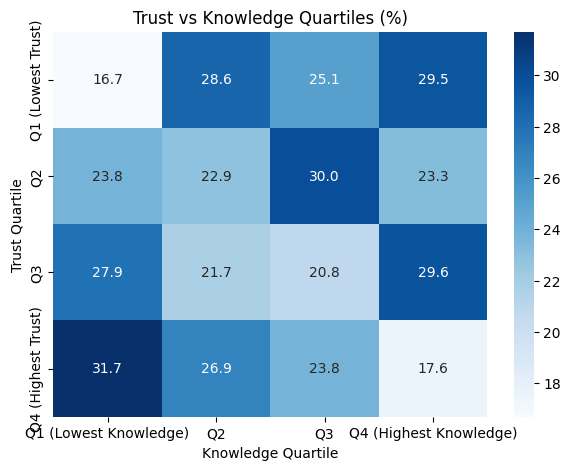

In [ ]:
# Drop missing indices
df = survey_df[['trust_index', 'knowledge_index']].dropna()

# Rank first to avoid duplicate edges
trust_ranks = df['trust_index'].rank(method='first', pct=True)
knowledge_ranks = df['knowledge_index'].rank(method='first', pct=True)

# Quartiles
trust_q = pd.qcut(trust_ranks, q=4, labels=['Q1 (Lowest Trust)', 'Q2', 'Q3', 'Q4 (Highest Trust)'])
knowledge_q = pd.qcut(knowledge_ranks, q=4, labels=['Q1 (Lowest Knowledge)', 'Q2', 'Q3', 'Q4 (Highest Knowledge)'])

# Cross-tab
ct = pd.crosstab(trust_q, knowledge_q)
ct_perc = (ct.div(ct.sum(axis=1), axis=0) * 100).round(1)

# Heatmap
plt.figure(figsize=(7,5))
sns.heatmap(ct_perc, annot=True, cmap='Blues', fmt='.1f')
plt.title('Trust vs Knowledge Quartiles (%)')
plt.xlabel('Knowledge Quartile')
plt.ylabel('Trust Quartile')
plt.show()

#### Trust Quartiles by Neighborhood Type

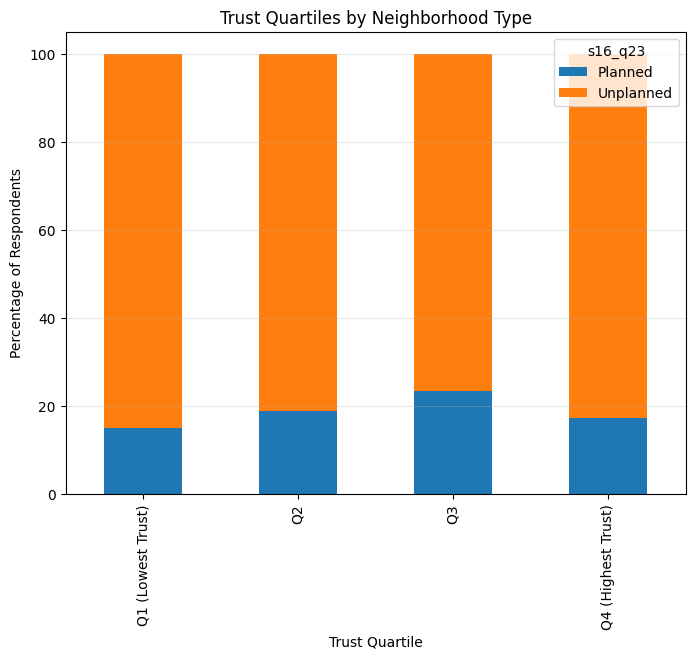

In [ ]:
# Keep rows with valid neighborhood type and trust index
mask_nbd = survey_df['s16_q23'].astype(str).str.strip(" ,\"'").isin(['Yes', 'No'])
mask_tr  = survey_df['trust_index'].notna()
df = survey_df.loc[mask_nbd & mask_tr, ['s16_q23','trust_index']].copy()

nbd = df['s16_q23'].astype(str).str.strip(" ,\"'").map({'Yes':'Planned','No':'Unplanned'})

# Bin trust into quartiles robustly (avoid duplicate-edge errors via rank→cut)
tr_pct = df['trust_index'].rank(method='first', pct=True)
trust_q = pd.cut(
    tr_pct, bins=[0, .25, .50, .75, 1.0],
    labels=['Q1 (Lowest Trust)', 'Q2', 'Q3', 'Q4 (Highest Trust)'],
    include_lowest=True
)

# Cross-tab: counts and row-wise percentages
ct = pd.crosstab(trust_q, nbd)
ct_perc = (ct.div(ct.sum(axis=1), axis=0) * 100).round(1)

ax = ct_perc.plot(kind='bar', stacked=True, figsize=(8,6))
ax.set_title('Trust Quartiles by Neighborhood Type')
ax.set_xlabel('Trust Quartile')
ax.set_ylabel('Percentage of Respondents')
ax.grid(axis='y', alpha=0.3)


### Fairness-Perception Index

This will capture people's sensitivity towards or concern for fairness.
Higher indices mean more concern or preference for fairness. And intuitively, a high preference for fairness should mean a stronger support for progressive tex reforms as they impose higher taxes on wealthier people and lower on poorer.

Note: only 1437 observations had at least one non-null response for the columns used to create the index, so this index is not calculated for all 4222 respondents.

In [4]:
# manual coding for which responses hint towards a preference for fairness

fairness_criteria = {
  #wealth inequality is a big problem in Lahore today
  's8_q1': lambda x: x.map({'Strongly agree': 5, 'Agree to some extent': 4, 'Neutral.': 3, 'Disagree to some extent': 2, 'Strongly disagree': 1}),
  #The extent of wealth inequality in Lahore today is unfair because wealthy families can give large inheritances to their childre
  's8_q3': lambda x: x.map({'Strongly agree': 5, 'Agree to some extent': 4, 'Neutral.': 3, 'Disagree to some extent': 2, 'Strongly disagree': 1}),
  #Large property owners in Lahore deserve their wealth since they worked hard and saved to accumulate wealth
  's8_q4': lambda x: x.map({'Strongly agree': 1, 'Agree to some extent': 2, 'Neutral.': 3, 'Disagree to some extent': 4, 'Strongly disagree': 5}),
  #Property taxes should be levied because income from owning property does not require property owners to work hard to earn that income
  's8_q5': lambda x: x.map({'Strongly agree': 5, 'Agree to some extent': 4, 'Neutral.': 3, 'Disagree to some extent': 2, 'Strongly disagree': 1}),
  #Property taxes should be levied because occupants enjoy the benefits of public services and so should contribute to their costs
  's8_q7': lambda x: x.map({'Strongly agree': 5, 'Agree to some extent': 4, 'Neutral.': 3, 'Disagree to some extent': 2, 'Strongly disagree': 1}),
  #People should only pay taxes if government gives them better services
  's8_q14': lambda x: x.map({'Strongly agree': 5, 'Agree to some extent': 4, 'Neutral.': 3, 'Disagree to some extent': 2, 'Strongly disagree': 1}),
  #How justifiable is it to evade taxes on a scale of 1 (totally justifiable) to 10 (totallyunjustifiable)
  's8_q17': lambda x: x.map({0: 0, 1:1, 2:2, 3:3, 4:4, 5:5, 6:6, 7:7, 8:8, 9:9, 10:10}),
  #Would you say that the current property tax system in Punjab is
  's8_q18': lambda x: x.map({'Very unfair.': 4, 'Somewhat unfair.': 3, 'Somewhat fair.': 2, 'Broadly very fair.': 1}),
  #ould you say that wealthy households in Lahore today:
  's8_q20': lambda x: x.map({'Pay much less than their fair share in property taxes.': 5, 'Pay less than their fair share in property taxes.': 4, 'Did not pay at all': 6, 'Pay roughly the right amount in property taxes.': 3,'Pay more than their fair share in property taxes.':2,'Pay much more than their fair share in property taxes.':1}),
  #Would you say that middle-class households in Lahore today:
  's8_q21': lambda x: x.map({'Pay much less than their fair share in property taxes.': 2, 'Pay less than their fair share in property taxes.': 3, 'Did not pay at all': 1, 'Pay roughly the right amount in property taxes.': 4,'Pay more than their fair share in property taxes.':5,'Pay much more than their fair share in property taxes.':6})
}

scores = []

for q, scoring_func in fairness_criteria.items():
    if q in survey_df.columns:
        s = scoring_func(survey_df[q])
        scores.append(s)

# Combine all scores into one Fairness Perception Index
survey_df['fairness_index'] = np.nanmean(np.column_stack(scores), axis=1)
survey_df['fairness_index'] = (
    (survey_df['fairness_index'] - survey_df['fairness_index'].min()) /
    (survey_df['fairness_index'].max() - survey_df['fairness_index'].min())
)
survey_df['fairness_index'].count()

/tmp/ipython-input-2390440405.py:34: RuntimeWarning: Mean of empty slice
  survey_df['fairness_index'] = np.nanmean(np.column_stack(scores), axis=1)
/tmp/ipython-input-2390440405.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  survey_df['fairness_index'] = np.nanmean(np.column_stack(scores), axis=1)


np.int64(1437)

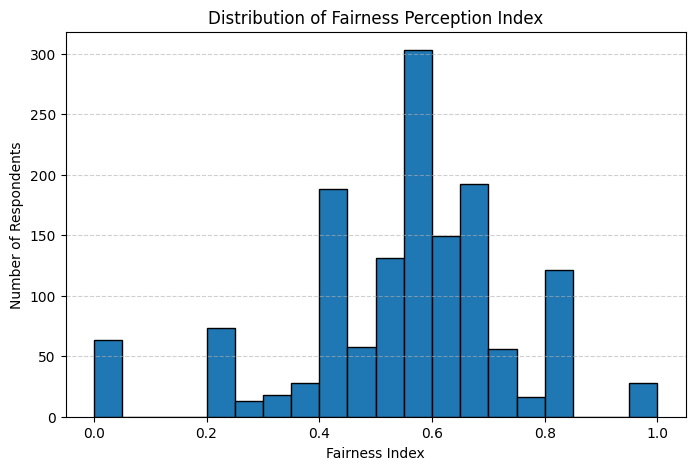

In [5]:
plt.figure(figsize=(8,5))
plt.hist(survey_df['fairness_index'], bins=20, edgecolor='black')
plt.title('Distribution of Fairness Perception Index')
plt.xlabel('Fairness Index')
plt.ylabel('Number of Respondents')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


### Expected impacts of raising top rates vs broad-base increases

Looking at the means, we can see that people expect higher impact (mean=3) of a tax increase policy on the broader
public (low/middle) class than upper class (mean=2).

count    907.000000
mean       0.421904
std        0.190195
min        0.000000
25%        0.277778
50%        0.444444
75%        0.555556
max        1.000000
Name: expected_impact, dtype: float64


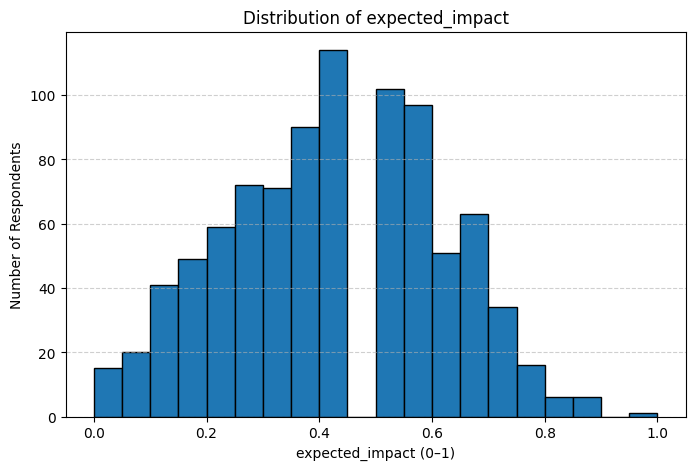

In [ ]:
# Coding of values from text to numeric

expected_impact_criteria = {
  #Imagine that the Government of Punjab decided to increase the property tax rates for high-value properties. We’d like to ask you what impacts you think that would have.
  #How much would this reduce overall economic activity in Lahore?
  's6_q1': lambda x: x.map({'A great deal.': 5, 'A lot.': 4, 'A moderate amount.': 3, 'A little.': 2,'None at all.':1}),
  #How much would this increase the gap between what owners of high-value properties are asked to pay and what is actually collected from them?
  's6_q2': lambda x: x.map({'A great deal.': 5, 'A lot.': 4, 'A moderate amount.': 3, 'A little.': 2,'None at all.':1}),
  #How much would it reduce the amount that the owners of those high-value propertiesinvest in their properties
  's6_q3': lambda x: x.map({'A great deal.': 5, 'A lot.': 4, 'A moderate amount.': 3, 'A little.': 2,'None at all.':1}),
  #How much would it reduce the construction of new properties?
  's6_q4': lambda x: x.map({'A great deal.': 5, 'A lot.': 4, 'A moderate amount.': 3, 'A little.': 2,'None at all.':1}),
  #How much would it increase the number of occupants of these high-value propertieswho move to another home?
  's6_q5': lambda x: x.map({'A great deal.': 5, 'A lot.': 4, 'A moderate amount.': 3, 'A little.': 2,'None at all.':1}),

  #An alternative policy the Government of Punjab could pursue to raise more revenue is to increase property tax rates for low- and medium-value properties instead of high-value properties. We’d like to ask you what impacts you think that would have
  #How much would this reduce overall economic activity in Lahore?
  's6_q6': lambda x: x.map({'A great deal.': 5, 'A lot.': 4, 'A moderate amount.': 3, 'A little.': 2,'None at all.':1}),
  #How much would this increase the gap between what owners of high-value properties are asked to pay and what is actually collected from them?
  's6_q7': lambda x: x.map({'A great deal.': 5, 'A lot.': 4, 'A moderate amount.': 3, 'A little.': 2,'None at all.':1}),
  #How much would it reduce the amount that the owners of those high-value propertiesinvest in their properties
  's6_q8': lambda x: x.map({'A great deal.': 5, 'A lot.': 4, 'A moderate amount.': 3, 'A little.': 2,'None at all.':1}),
  #How much would it reduce the construction of new properties?
  's6_q9': lambda x: x.map({'A great deal.': 5, 'A lot.': 4, 'A moderate amount.': 3, 'A little.': 2,'None at all.':1}),
  #How much would it increase the number of occupants of these high-value propertieswho move to another home?
  's6_q10': lambda x: x.map({'A great deal.': 5, 'A lot.': 4, 'A moderate amount.': 3, 'A little.': 2,'None at all.':1}),
}

# 1) Apply mappings in-place (assumes prog_tax_support_criteria is already defined)
for q, func in expected_impact_criteria.items():
    if q in survey_df.columns:
        survey_df[q] = func(survey_df[q])

# 2) Select variables (progressive-tax items)
impact_vars = ['s6_q1','s6_q2','s6_q3','s6_q4','s6_q5','s6_q6','s6_q7','s6_q8','s6_q9']

# 3) Ensure numeric
survey_df[impact_vars] = survey_df[impact_vars].apply(pd.to_numeric, errors='coerce')

# 4) Row-wise mean (unscaled index)
survey_df['expected_impact'] = survey_df[impact_vars].mean(axis=1)

# 5) Safe min–max normalization to 0–1
x = survey_df['expected_impact']
if x.notna().any():
    x_min, x_max = x.min(), x.max()
    if pd.isna(x_min) or pd.isna(x_max) or x_min == x_max:
        survey_df['expected_impact'] = np.nan  # or a constant like 0.5
    else:
        survey_df['expected_impact'] = (x - x_min) / (x_max - x_min)
else:
    survey_df['expected_impact'] = np.nan

print(survey_df['expected_impact'].describe())

# Optional plot (robust to all-NaN)
vals = survey_df['expected_impact'].dropna()
if not vals.empty:
    plt.figure(figsize=(8,5))
    plt.hist(vals, bins=20, edgecolor='black')
    plt.title('Distribution of expected_impact')
    plt.xlabel('expected_impact (0–1)')
    plt.ylabel('Number of Respondents')
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.show()
else:
    print("No finite values to plot after normalization.")



### Support for progressive taxes

Using 4 variables that reveal the respondent's attitude towards progressive or regressive taxes, I've created an index, support_progressive_tax, that captures this attitude. However, due to many null values (3315 null out of 4222), this index will not be too informative.

/tmp/ipython-input-3123432068.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  survey_df['support_progressive_tax'] = survey_df[prog_tax_vars].mean(axis=1)


count    907.000000
mean       0.440279
std        0.172856
min        0.000000
25%        0.333333
50%        0.416667
75%        0.583333
max        1.000000
Name: support_progressive_tax, dtype: float64


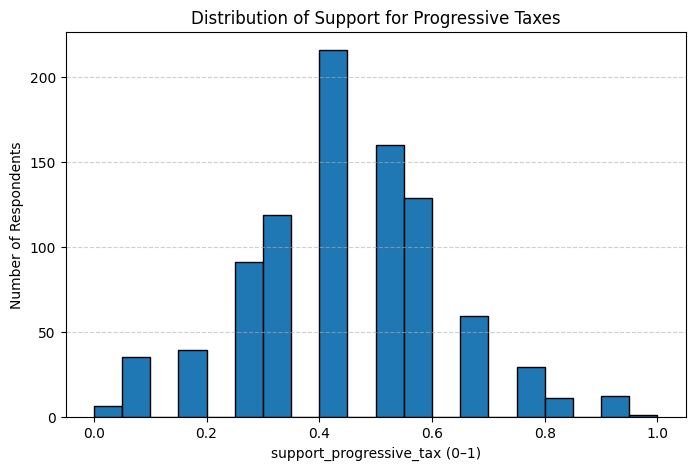

In [3]:
# Manually defined criteria for what responses indicate suppor for progressive taxes

prog_tax_support_criteria = {
  #Imagine that the Government of Punjab decided to increase the property tax rates for high-value properties. We’d like to ask you what impacts you think that would have.
  #How much would this reduce overall economic activity in Lahore?
  's6_q1': lambda x: x.map({'A great deal.': 1, 'A lot.': 2, 'A moderate amount.': 3, 'A little.': 4,'None at all.':5}),
  #How much would it reduce the construction of new properties?
  's6_q4': lambda x: x.map({'A great deal.': 1, 'A lot.': 2, 'A moderate amount.': 3, 'A little.': 4,'None at all.':5}),
  #An alternative policy the Government of Punjab could pursue to raise more revenue is to increase property tax rates for low- and medium-value properties instead of high-value properties. We’d like to ask you what impacts you think that would have
  #How much would this reduce overall economic activity in Lahore?
  's6_q6': lambda x: x.map({'A great deal.': 5, 'A lot.': 4, 'A moderate amount.': 3, 'A little.': 2,'None at all.':1}),
  #How much would it reduce the construction of new properties?
  's6_q9': lambda x: x.map({'A great deal.': 5, 'A lot.': 4, 'A moderate amount.': 3, 'A little.': 2,'None at all.':1})
}

scores = []

# Apply mappings
for q, func in prog_tax_support_criteria.items():
    if q in survey_df.columns:
        survey_df[q] = func(survey_df[q])

prog_tax_vars = ['s6_q1', 's6_q4', 's6_q6', 's6_q9']
survey_df[prog_tax_vars] = survey_df[prog_tax_vars].apply(pd.to_numeric, errors='coerce')

survey_df['support_progressive_tax'] = survey_df[prog_tax_vars].mean(axis=1)

# Min–max normalization to 0–1
x = survey_df['support_progressive_tax']
x_min, x_max = x.min(), x.max()
if x.notna().any() and pd.notna(x_min) and pd.notna(x_max) and x_min != x_max:
    survey_df['support_progressive_tax'] = (x - x_min) / (x_max - x_min)
else:
    survey_df['support_progressive_tax'] = np.nan  # or a constant like 0.5

print(survey_df['support_progressive_tax'].describe())

vals = survey_df['support_progressive_tax'].dropna()
if not vals.empty:
    plt.figure(figsize=(8,5))
    plt.hist(vals, bins=20, edgecolor='black')
    plt.title('Distribution of Support for Progressive Taxes')
    plt.xlabel('support_progressive_tax (0–1)')
    plt.ylabel('Number of Respondents')
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.show()
else:
    print("No finite values to plot after normalization.")


### Fairness Perception vs Support for Progressive Taxation

The regplot shows us that people with a high sense of fairness moderately show more support for progressive taxes.However, the current data is limited as only 907 out of 4222 observations had at least one non-null response for the questions that were included in the tax support index. Similarly, only 1437 out of 4222 observations had at least one non-null response for the questions that were included in the fairness index.

But intuitively, we can trust that people with a high sense of fairness will support progressive tax reforms, so the trend shown in the regplot holds intuitive sense and corroborates this hypothesis.

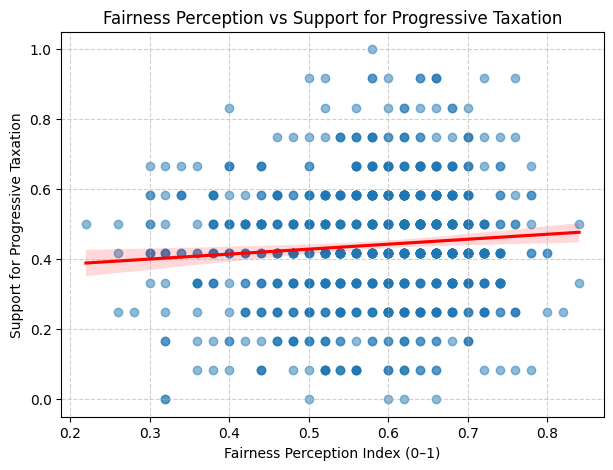

In [6]:
plt.figure(figsize=(7,5))
sns.regplot(
    data=survey_df,
    x='fairness_index',
    y='support_progressive_tax',
    scatter_kws={'alpha':0.5},
    line_kws={'color':'red'}
)
plt.title('Fairness Perception vs Support for Progressive Taxation')
plt.xlabel('Fairness Perception Index (0–1)')
plt.ylabel('Support for Progressive Taxation')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

#### Trust vs Concern for fairness

People with high concern for fairness are associated with lesser trust of institutions

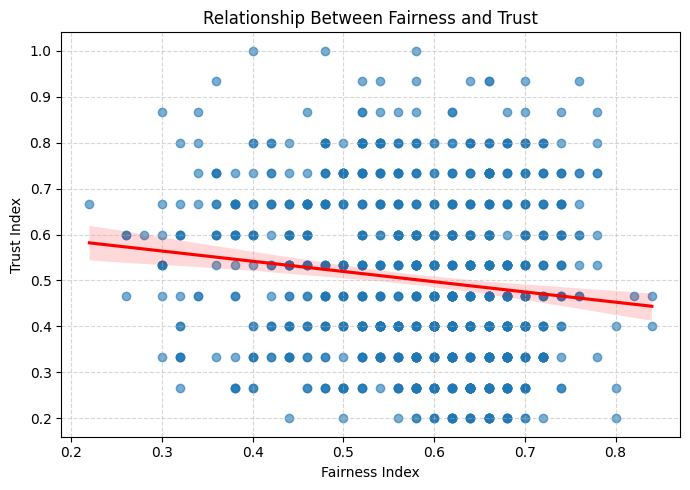

In [ ]:
plt.figure(figsize=(7,5))
sns.regplot(
    data=survey_df,
    x='fairness_index',
    y='trust_index',
    scatter_kws={'alpha':0.6},
    line_kws={'color':'red'}
)
plt.title('Relationship Between Fairness and Trust')
plt.xlabel('Fairness Index')
plt.ylabel('Trust Index')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


## Policy Implications

### Citizen typology

1. Fairness-Driven Progressives (around 35–40%)

    Profile: High fairness index, believe inequality is a serious issue.

    View: Support raising top property tax rates

    Trust: Low trust in government institutions


2. Skeptical Pragmatists (around 30–35%)

    Profile: Moderate fairness score

    View: Support moderate reform but fear unintended consequences

    Trust: Mixed; want proof of transparent use of funds

3. Status-Quo Defenders (around 25–30%)

    Profile: Low fairness index, see current tax structure as acceptable.

    View: Oppose raising rates on any group, citing risks to investment and property values.

    Trust: High institutional trust



### Actionable Insights

* Frame the Reform as “Fairness with Accountability.”

    Launch a communication campaign telling that high-value properties will contribute more, ensuring everyone pays their fair share.

    Publish a Property Tax Impact Report each fiscal year showing exactly how revenue improves services (roads, sanitation, public facilities).

* Sequence Implementation Progressively.

    Phase 1: Adjust tax rates for high-value properties first. Align with public fairness expectations and minimize perceived harm.

    Phase 2: Introduce compliance reforms and expand coverage, paired with exemptions or rebates for low-income or small property owners.

    Phase 3: Evaluate outcomes publicly before any broad-base increase.

* Build Procedural Fairness and Institutional Trust.

    Digitize assessments, billing, and grievance systems to reduce discretion and corruption.

    Involve citizens and local councils in monitoring and feedback through open dashboards or public hearings.

    Publish quarterly transparency updates showing tax collection and expenditure by district.

### Sequencing Recommendations for 2025 Reform

* Phase 1 – Communication and Consultation (Q1–Q2):

    Publicize why reform is needed by focusing on fairness, transparency, and efficiency.

    Engage professional bodies like property owners’ associations, urban planners to discuss tax rate design.

* Phase 2 – Pilot and Demonstrate (Q3):

    Introduce progressive top-rate changes first (on high-value properties).

    Complement these with visible service improvements funded by the reform (street upgrades, municipal works).

* Phase 3 – Broader Compliance Reform (Q4):

    Strengthen collection mechanisms and close any assessment gaps.

    Communicate fair enforcement and administration of tax rates

## Task 5 - Merge Payments and Survey Data

In [ ]:
payments_df=pd.read_stata('/content/drive/MyDrive/my_payments_data.dta')

In [ ]:
merged = pd.merge(payments_df, survey_df, on='pin', how='inner')


In [ ]:
outcomes = ['paid_share', 's4_q6', 's4_q18']
treatment_summary = (
    merged.groupby(['treatment', 'treatment_s'])[outcomes]
    .mean()
    .reset_index()
    .sort_values('treatment')
)

treatment_summary


,treatment,treatment_s,paid_share,s4_q6,s4_q18
0,1,No Correcting Misperceptions,0.914709,20.272727,NaN
1,2,Correcting Misperceptions,0.984635,20.136364,NaN
2,3,Public Goods,1.012119,26.833333,NaN
3,4,Revenue Leakage,1.015076,21.705882,NaN
4,5,Spending Leakage,1.032105,26.166667,22.611111
5,6,Elite Capture,1.009574,29.714286,NaN


Across the six treatment arms, behavioral responses (measured by paid_share) were generally high and varied slightly across groups, while beliefs about government spending efficiency showed larger differences. Treatments emphasizing public goods, spending leakage, and elite capture raise expectations about how much of citizens’ taxes would be spent on preferred public services. However, these changes in beliefs did not translate equally into higher payment rates, suggesting a belief and behavior gap. Even when citizens doubted government spending efficiency, compliance remained strong, implying that behavioral responses are influenced by obligation or enforcement rather than confidence in institutions. This highlights the need for communication strategies that strengthen perceived fiscal accountability. Demonstrating transparent and visible use of property tax revenues could convert compliant behavior into lasting trust.

In [ ]:
file_path = '/content/drive/MyDrive/my_survey_data.dta'
survey_df.to_stata(file_path, write_index=False)

file_path = '/content/drive/MyDrive/my_merged_data.dta'
merged.to_stata(file_path, write_index=False)

### Self Assessment

I'd rate my reliance on GPT as 3. However, if I had more time to complete the assignment I would have used more brain in writing the actual code as well rather than just the strategy and debugging.